# Детектирование объектов. Часть 1.
Классификация и локализация

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

In [2]:
import random
import numpy as np
import skimage.filters
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf

## Загрузка и подготовка оригинального датасета MNIST

In [3]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

11501568/11490434 [==============================] - 0s 0us/step


## Подготовка фона для новых изображений

Берем случайную матрицу 1000х1000 и с помощью гаусовской фильтрации размоем фон


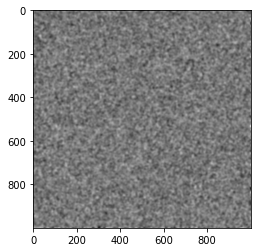

In [5]:
bg_source = np.random.rand(1000, 1000, 1).astype(np.float32)
bg_source = skimage.filters.gaussian(bg_source, 4)
bg_source = (bg_source - np.min(bg_source))/(np.max(bg_source) - np.min(bg_source))
# нормализуем чтобы был от 0 до 1
bg_source = np.clip(bg_source, 0, 1)

_=plt.imshow(bg_source[..., 0], 'gray')

## Функция для конвертации MNIST в датасет для локализации

In [6]:
def convert_to_loc_ds(x, y, bg_source, new_size):
    x_new = np.zeros((x.shape[0], new_size[0], new_size[1], 1), dtype=np.float32)
    y_new = np.zeros((y.shape[0], 10, 5), dtype=np.float32)
    y_new[:, :, 1:] = -1

    rh = float(x.shape[1]) / new_size[0]
    rw = float(x.shape[2]) / new_size[1]

    for i in range(x.shape[0]):
      # координаты подфона, который мы берем из большого фона
        oh = random.randint(0, bg_source.shape[0] - new_size[0])
        ow = random.randint(0, bg_source.shape[1] - new_size[1])
        # вырезаем произвольный кусок фона 64х64
        x_new[i] = bg_source[oh:oh+new_size[0], ow:ow+new_size[1], :]
        # выбираем рандомное место в фоне, куда хотим подставить наше число из MNIST
        oh = random.randint(0, x_new[i,...].shape[0] - x[i].shape[0])
        ow = random.randint(0, x_new[i,...].shape[1] - x[i].shape[1])
        # Подставляем картинку(прибавляем)
        # фон прибавится как 0 к исходному фону, а циферка станет >1
        x_new[i, oh:oh+x[i].shape[0], ow:ow+x[i].shape[1], :] += x[i]
        # обрезаем значения >1
        x_new[i] = np.clip(x_new[i], 0, 1)
        ry = float(oh) / new_size[0]
        rx = float(ow) / new_size[1]
        # [вероятность класса, bounding box] записываем в нашу матрицу
        y_new[i][y[i]] = [1.0, ry, rx, rh, rw]
        
    return x_new, y_new

## Генерация локализационного датасета


In [7]:
new_size = (64, 64)

train_x_new, train_y_new = convert_to_loc_ds(train_x, train_y, bg_source, new_size)
test_x_new, test_y_new = convert_to_loc_ds(test_x, test_y, bg_source, new_size)

print(train_x_new.shape)
print(train_y_new.shape)
print(test_x_new.shape)
print(test_y_new.shape)

(60000, 64, 64, 1)
(60000, 10, 5)
(10000, 64, 64, 1)
(10000, 10, 5)


## Фнкция для визуализации локализации

In [8]:
def show_prediction(x, logits):
    pred_cls = np.argmax(logits[:,0])
    ry, rx, rh, rw = logits[pred_cls][1:]

    box_y = round(ry * x.shape[0])
    box_x = round(rx * x.shape[1])
    box_h = round(rh * x.shape[0])
    box_w = round(rw * x.shape[1])

    fig,ax = plt.subplots(1)
    ax.imshow(x[...,0], 'gray', vmin=0, vmax=1,)
    rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    print('Prediction: {}'.format(pred_cls))
    print('Box: {}'.format((box_x, box_y, box_w, box_h)))

## Визуализация Ground-Truth образца

Prediction: 4
Box: (36, 22, 28, 28)


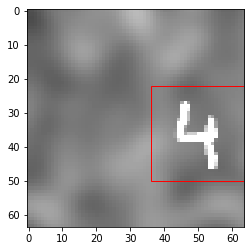

In [11]:
i = random.randint(0, train_x_new.shape[0])
show_prediction(train_x_new[i], train_y_new[i])

## Создание модели для классификации и локализации

In [12]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), activation=tf.nn.relu, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), activation=tf.nn.relu, padding='same')
        self.conv3 = tf.keras.layers.Conv2D(128, (5, 5), activation=tf.nn.relu, padding='same')
        self.conv4 = tf.keras.layers.Conv2D(128, (5, 5), activation=tf.nn.relu, padding='same')
        self.fc1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        # на выходе выдаем матрицу 10х5(кол-во классов на 5), но тут перемножаем и получаем один вектор размерности 50
        self.fc2 = tf.keras.layers.Dense(5*10, activation=None)
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, inp):
        
        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.conv3(out)
        out = self.max_pool(out)
        out = self.conv4(out)
        out = self.max_pool(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        # получили 50 чисел на выходе и преобразуем эти числа к 3-мерному тензору
        out = tf.reshape(out, (-1, out.shape[1]//5, 5))
        
        return out
    
model = Model()

## Функция потерь (Loss)

In [13]:
def loss_cls(labels, logits):
    logits_cls = logits[:,:,0]
    labels_cls = labels[:,:,0]
    return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
        labels_cls, logits_cls, from_logits=True))

def loss_box(labels, logits):
    logits_box = logits[:,:,1:]
    labels_box = labels[:,:,1:]
    return tf.reduce_mean(tf.keras.losses.MSE(
        labels_box, logits_box))

LAMBDA = 10.0
# Общий лосс для потери класса и бокса. Чтобы их суммировать нам нужен некоторый параметр lambda, чтобы уровнять баланс в потерях
def loss_composit(labels, logits):
    return loss_cls(labels, logits) + LAMBDA * loss_box(labels, logits)

## Обучение модели

Epoch 1/20
938/938 [==============================] - 72s 43ms/step - loss: 2.8666
Epoch 2/20
938/938 [==============================] - 41s 43ms/step - loss: 0.2847
Epoch 3/20
938/938 [==============================] - 40s 43ms/step - loss: 0.1469
Epoch 4/20
938/938 [==============================] - 40s 43ms/step - loss: 0.0968
Epoch 5/20
938/938 [==============================] - 40s 43ms/step - loss: 0.0731
Epoch 6/20
938/938 [==============================] - 40s 43ms/step - loss: 0.0606
Epoch 7/20
938/938 [==============================] - 40s 43ms/step - loss: 0.0487
Epoch 8/20
938/938 [==============================] - 40s 43ms/step - loss: 0.0407
Epoch 9/20
938/938 [==============================] - 40s 43ms/step - loss: 0.0269
Epoch 10/20
938/938 [==============================] - 40s 43ms/step - loss: 0.0318
Epoch 11/20
938/938 [==============================] - 40s 43ms/step - loss: 0.0274
Epoch 12/20
938/938 [==============================] - 40s 43ms/step - loss: 0.0161
E

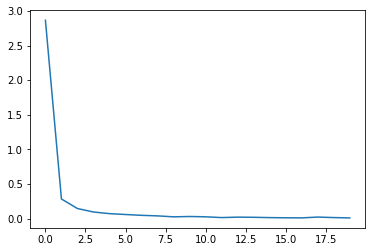

In [14]:
NUM_EPOCHS = 20
BATCH_SIZE = 64

model.compile(optimizer='adam', loss=loss_composit)

hist = model.fit(train_x_new, train_y_new, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

plt.plot(hist.history['loss'])

## Тестирование модели

Prediction: 1
Box: (33, 33, 28, 28)


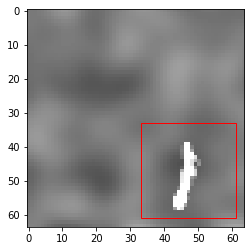

In [23]:
i = random.randint(0, test_x_new.shape[0])
sample = test_x_new[i]
          
pred = model.predict(sample[None, ...])[0, ...]
show_prediction(sample, pred)